<a href="https://colab.research.google.com/github/AlekseiShevkoplias/Intragenic/blob/rubbish/CurrentPalGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate, Lambda, Add, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [9]:
import random
import pandas as pd
from keras import Sequential
from keras.layers import Embedding
from keras.layers import LSTM, Input
from keras.layers import Dense
from keras import backend as K
import numpy as np

COMPLEMENT = {
    'A': 'T',
    'G': 'C',
    'T': 'A', 
    'C': 'G'
}

NUC = ['A', 'T', 'G', 'C']

TOKENS = {
    'A': [1, 0, 0, 0],
    'G': [0, 1, 0, 0],
    'T': [0, 0, 1, 0], 
    'C': [0, 0, 0, 1], 
    'X': [0, 0, 0, 0]
}

def tokenize(seq):
    tokenized = []
    for nuc in seq:
        tokenized.append(TOKENS[nuc])
    return tokenized

def generate_palindromes(n):
    """
    Generates n DNA palindromes.
    n: the number of palindromes to be generated
    """
    palindromes = []
    for j in range(n):
  
        pal_length = random.randint(2, 10)

        palindrome = ''
        for i in range(50 - pal_length):
            palindrome += random.choice(NUC)

        for i in range(pal_length):
            palindrome += random.choice(NUC)

        for i in range(pal_length - 1, -1, -1):
            palindrome += COMPLEMENT[palindrome[i]]
        
        for i in range(50 - pal_length):
            palindrome += random.choice(NUC)


        palindromes.append(palindrome)

    return palindromes


def generate_sd(n):
    """
    Generates n DNA with inserted SD.
    n: the number of palindromes to be generated.
    """
    sds = []
    for i in range(n):
        sd = ''
        for i in range(47):
            sd += random.choice(NUC)
        sd += 'AGGAGG'
        for i in range(47):
            sd += random.choice(NUC)

        sds.append(sd)

    return sds

def test_sd(seq):
    if 'AGGAGG' in seq[47:54]:
        return True
    return False

def test_palindrome(seq):
    """
    Tests whether the seq is a DNA palindrome or not.
    seq: A str object with the DNA sequence
    return: True if seq is a palindrome and False if not
    """
    assert isinstance(seq, str)
    complementary = ''
    for i in range(len(seq)//2 - 1, -1, -1):
        complementary += COMPLEMENT[seq[i]]
    return complementary == seq[len(seq)//2:]

def generate_negatives(n):
    """
    Generates n DNA non-palindromes.
    n: the number of negatives to be generated
    """
    negs = []
    for j in range(n):
        is_palindrome = True
        neg_length = random.randint(2, 10) * 2
        preneg = ''

        for i in range(50 - neg_length//2):
            preneg += random.choice(NUC)

        while is_palindrome:
            

            neg = ''

            for i in range(neg_length):
                neg += random.choice(NUC)

            is_palindrome = test_palindrome(neg) or test_sd(neg)
        neg = preneg + neg

        for i in range(50 - neg_length//2):
            neg += random.choice(NUC)

        negs.append(neg)

    return negs

def generate_rubbish(n):
    """
    Negative with X in the middle
    """
    rubbishes = []
    for i in range(n):
        rubbish = ''
        for i in range(50):
            rubbish += random.choice(NUC)
        rubbish += 'X'
        for i in range(49):
            rubbish += random.choice(NUC)
        rubbishes.append(rubbish)

    return rubbishes

class PalNegDataset:
    def __init__(self, n_pal, n_sd, n_neg, n_rubbish = 0):
        
        self.n_pal = n_pal
        self.n_sd = n_sd
        self.n_neg = n_neg
        self.n_rubbish = n_rubbish

        self.palindromes = generate_palindromes(n_pal)
        self.sds = generate_sd(n_sd)
        self.negatives = generate_negatives(n_neg)
        self.data = self.generate_data()
        self.sequences = self.palindromes + self.sds + self.negatives

        random.shuffle(self.sequences)
        self.status = K.constant([self.data[key] for key in self.sequences])
        self.tokenized_seq = np.array([tokenize(seq) for seq in self.sequences])
        self.middles = np.array([tokenize(seq[50]) for seq in self.sequences])

        # different stuff (likely will be deleted later)
        self.palmiddles = np.array([tokenize(seq[50]) for seq in self.palindromes])
        self.palmiddles = self.palmiddles.reshape([self.palmiddles.shape[0], 4])

        if self.n_rubbish > 0:
            self.rubbish = generate_rubbish(n_rubbish)
            self.rubbish_middles = np.array([tokenize(seq[50]) for seq in self.rubbish])
            self.rubbish_middles = self.rubbish_middles.reshape([self.rubbish_middles.shape[0], 4])
            self.tokenized_rubbish = np.array([tokenize(seq) for seq in self.rubbish])
            self.tokenized_rubbish = np.array([np.append(np.append(seq[:50], np.array([[0, 0, 0, 0]]), axis=0), seq[51:], axis = 0) for seq in self.tokenized_rubbish])

        self.tokenized_pals = np.array([tokenize(seq) for seq in self.palindromes])
        self.tokenized_pals = np.array([np.append(np.append(seq[:50], np.array([[0, 0, 0, 0]]), axis=0), seq[51:], axis = 0) for seq in self.tokenized_pals])

    def __len__(self):
        return self.n_pal + self.n_neg

    def generate_data(self):
        data = {}
        for pal in self.palindromes:
            data[pal] = 1
        for sd in self.sds:
            data[sd] = 1
        for neg in self.negatives:
            data[neg] = 0        
        return data
    


        

In [10]:
t = PalNegDataset(5000, 0, 5000, n_rubbish=5000)

In [ ]:
t.status[100:200]

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>

In [ ]:
trainX = t.tokenized_seq[:7000]
testX = t.tokenized_seq[7000:9000]
valX = t.tokenized_seq[9000:]
trainY = t.status[:7000]
testY = t.status[7000:9000]
valY = t.status[9000:]


In [ ]:
trainX.shape

(7000, 100, 4)

In [11]:
# палиндромы для проверки предсказания нуклеотида
frX_train = t.tokenized_pals[:4000] + t.tokenized_rubbish[:4000] 
frY_train = t.palmiddles[:4000] + t.rubbish_middles[:4000]

frX_val = t.tokenized_pals[4000:] + t.tokenized_rubbish[4000:] 
frY_val = t.palmiddles[4000:]+ t.rubbish_middles[4000:]

In [ ]:
frX_train.shape

(4000, 100, 4)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 32)      1312        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 32)      1312        input_1[0][0]                    
__________________________________________________________________________________________________
attention (Attention)           (None, 100, 4)       0           conv1d[0][0]                     
                                                                 input_1[0][0]                

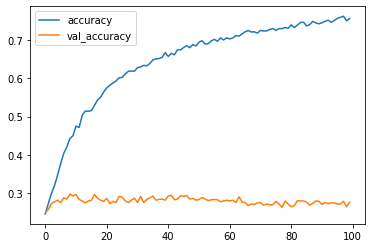

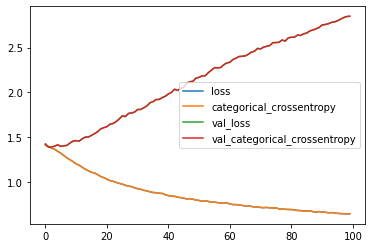

In [12]:
# From find_repeat
ms = []

def run_model():
    inp = Input((100, 4))
    cur_p = Conv1D(filters=32, kernel_size=10, padding='SAME')(inp)
    cur_p2 = Conv1D(filters=32, kernel_size=10, padding='SAME')(inp)
    cur = Attention()([cur_p, inp, cur_p2])
    cur = Flatten()(cur)
    cur = Dense(4, activation='softmax')(cur)
    # cur = Dense(1, activation='softmax')(cur)
    model = Model(inp, cur)

    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy', 'categorical_crossentropy'])    
    model.summary()

    es = EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True)
    callbacks = []
    callbacks.append(es)

    history = model.fit(frX_train, frY_train, epochs=100,  batch_size=32, 
                         validation_data=(frX_val, frY_val), 
                         callbacks=[], verbose=1)

    def show(history, acc_on=True):
        for k, v in history.history.items():
            if int('acc' not in k) + int(acc_on) == 1:
                plt.plot(v, label=k)
        plt.legend()
        plt.show()
    show(history, True)
    show(history, False)

    ms.append(model)
    # loss, test_acc, test_cat = model.evaluate(test_q, test_ans, verbose=1)
    # return test_acc

accs = [run_model() for _ in range(1)]

In [ ]:
embedding_dim = 256
units = 64
vocab_in_size = 100
len_input_train = 4
BATCH_SIZE = 1


model_lstm = Sequential()
model_lstm.add(Input((100, 4)))
#model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=len_input_train))
model_lstm.add(LSTM(units))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

history_lstm = model_lstm.fit(trainX, trainY, 
                              epochs=10, batch_size=BATCH_SIZE, 
                              # verbose=2,
                              validation_data=(valX, valY))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17664     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1203/7000 [====>.........................] - ETA: 1:36 - loss: 5.8663e-08 - accuracy: 0.5021

KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import  Conv1D, GRU, LSTM, TimeDistributed, Concatenate, Softmax, Activation, Flatten, Dense, Input, Bidirectional, Attention
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras import layers 

import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"  # for tf 2.0

main_input = Input((100, 4))
cur_p1 = Conv1D(filters=16, kernel_size=3, padding='SAME')(main_input)
cur_p2 = Conv1D(filters=16, kernel_size=3, padding='SAME')(main_input)
cur1 = Attention()([cur_p1, main_input, cur_p2])

cur = Concatenate()([cur1, main_input])
cur = Bidirectional(GRU(4, return_sequences=True))(cur)

d = Dense(4, activation='relu') (cur)
d = TimeDistributed(Dense(1, activation='relu', kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1))) (d)

d = Flatten()(d)

main_output = d
model = Model(main_input, main_output)

model.compile(optimizer="adam", loss='mse', metrics=['mse', 'accuracy'])    

In [ ]:
len(trainX[0])

100

In [ ]:
history = model.fit(trainX, trainY, 
                              epochs=10, batch_size=BATCH_SIZE, 
                              # verbose=2,
                              validation_data=(valX, valY))

Epoch 1/10
7000/7000 [==============================] - 172s 25ms/step - loss: 0.2740 - mse: 0.2539 - accuracy: 0.0000e+00 - val_loss: 0.2557 - val_mse: 0.2502 - val_accuracy: 0.0000e+00
Epoch 2/10
7000/7000 [==============================] - 171s 24ms/step - loss: 0.2560 - mse: 0.2520 - accuracy: 0.0000e+00 - val_loss: 0.2542 - val_mse: 0.2514 - val_accuracy: 0.0000e+00
Epoch 3/10
7000/7000 [==============================] - 175s 25ms/step - loss: 0.2540 - mse: 0.2514 - accuracy: 0.0000e+00 - val_loss: 0.2563 - val_mse: 0.2537 - val_accuracy: 0.0000e+00
Epoch 4/10
7000/7000 [==============================] - 172s 25ms/step - loss: 0.2529 - mse: 0.2508 - accuracy: 0.0000e+00 - val_loss: 0.2550 - val_mse: 0.2528 - val_accuracy: 0.0000e+00
Epoch 5/10
7000/7000 [==============================] - 172s 25ms/step - loss: 0.2528 - mse: 0.2510 - accuracy: 0.0000e+00 - val_loss: 0.2555 - val_mse: 0.2536 - val_accuracy: 0.0000e+00
Epoch 6/10
7000/7000 [==============================] - 170s 24ms

KeyboardInterrupt: ignored

In [ ]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size,

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(100,4))
embedding_layer = TokenAndPositionEmbedding(100, 4, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

ValueError: ignored

In [ ]:
import tensorflow_datasets as tfds
tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

NameError: ignored

In [ ]:
d_model = 512
dff=2048
maximum_position_encoding = 10000
input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2

scaling_factor = tf.keras.backend.constant(np.sqrt(d_model), shape = (1,1,1))


tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

# Encoder ##################################
input = tf.keras.layers.Input(shape=(None,))

x = tf.keras.layers.Embedding(input_vocab_size, d_model)(input) #, mask_zero=True

## positional encoding
x = tf.keras.layers.Multiply()([x,scaling_factor])
pos = positional_encoding(maximum_position_encoding, d_model)
x = tf.keras.layers.Add()([x, pos[: , :tf.shape(x)[1], :]] )

## self-attention
query = tf.keras.layers.Dense(d_model)(x)
value = tf.keras.layers.Dense(d_model)(x)
key = tf.keras.layers.Dense(d_model)(x)
attention = tf.keras.layers.Attention()([query, value, key])                   # , mask=[query._keras_mask, value._keras_mask]
attention = tf.keras.layers.Dense(d_model)(attention)

x = tf.keras.layers.Add()([x , attention])
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

## Feed Forward
dense = tf.keras.layers.Dense(dff, activation='relu')(x)
dense = tf.keras.layers.Dense(d_model)(dense)
x = tf.keras.layers.Add()([x , dense])                                          # residual connection
encoder = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

# Decoder ##################################
target = tf.keras.layers.Input(shape=(None,))

x = tf.keras.layers.Embedding(target_vocab_size, d_model )(target) # , mask_zero=True

## positional encoding
x = tf.keras.layers.Multiply()([x,scaling_factor])
pos = positional_encoding(maximum_position_encoding, d_model)
x = tf.keras.layers.Add()([x, pos[: , :tf.shape(x)[1], :] ])

## self-attention
query = tf.keras.layers.Dense(d_model)(x)
value = tf.keras.layers.Dense(d_model)(x)
key = tf.keras.layers.Dense(d_model)(x)
attention = tf.keras.layers.Attention(causal = True)([query, value, key])       # , mask=[query._keras_mask, value._keras_mask]
attention = tf.keras.layers.Dense(d_model)(attention)

x = tf.keras.layers.Add()([x , attention])                                      # residual connection
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

## encoder-decoder attention
query = tf.keras.layers.Dense(d_model)(x)
value = tf.keras.layers.Dense(d_model)(encoder)
key = tf.keras.layers.Dense(d_model)(encoder)
attention = tf.keras.layers.Attention()([query, value, key])                    # , mask=[query._keras_mask, value._keras_mask]
attention = tf.keras.layers.Dense(d_model)(attention)

x = tf.keras.layers.Add()([x , attention])                                      # residual connection
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

## Feed Forward
dense = tf.keras.layers.Dense(dff, activation='relu')(x)
dense = tf.keras.layers.Dense(d_model)(dense)
x = tf.keras.layers.Add()([x , dense])                                          # residual connection
decoder = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

######################################################

x = tf.keras.layers.Dense(target_vocab_size)(decoder)

base_model = tf.keras.models.Model(inputs=[input,target], outputs=x)
base_model.summary()

NameError: ignored

In [ ]:
!pip install -U transformers-keras

     |████████████████████████████████| 51kB 1.6MB/s 


In [ ]:
df = pd.DataFrame({'x': trainX.flatten(), 'y': trainY.flatten()})

AttributeError: ignored

In [ ]:
from transformers_keras import BertTFRecordDatasetBuilder

builder = BertTFRecordDatasetBuilder(max_sequence_length=128, record_option='GZIP')

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy(name='acc')
model.compile(optimizer='adam', loss=loss, metrics=[metric])
model(model.dummy_inputs())
model.summary()

model.fit(train_dataset, epochs=2)

In [ ]:
class Transformer(tf.keras.layers.Layer):

    def __init__(self,
                 src_vocab_size=-1,
                 tgt_vocab_size=-1,
                 max_positions=512,
                 hidden_size=512,
                 num_encoder_layers=6,
                 num_decoder_layers=6,
                 num_attention_heads=8,
                 ffn_size=2048,
                 dropout_rate=0.2,
                 epsilon=1e-6,
                 **kwargs):
        super(Transformer, self).__init__(**kwargs)
        assert src_vocab_size > 0, "src_vocab_size must greater than 0."
        assert tgt_vocab_size > 0, "tgt_vocab_size must greater than 0."
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.max_positions = max_positions
        self.hidden_size = hidden_size
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.num_attention_heads = num_attention_heads
        self.ffn_size = ffn_size
        self.dropout_rate = dropout_rate
        self.epsilon = epsilon
        self.encoder = TransformerEncoder(
            src_vocab_size, max_positions, hidden_size,
            num_layers=num_encoder_layers, dropout_rate=dropout_rate, epsilon=epsilon)
        self.decoder = TransformerDecoder(
            tgt_vocab_size, max_positions, hidden_size,
            num_layers=num_encoder_layers, dropout_rate=dropout_rate, epsilon=epsilon)
        self.dense = tf.keras.layers.Dense(tgt_vocab_size)

    def call(self, inputs, training=None):
        x_ids, y_ids = inputs

        def _create_padding_mask(x):
            mask = tf.cast(tf.equal(0, x), dtype=tf.float32)
            mask = mask[:, tf.newaxis, tf.newaxis, :]
            return mask

        def _create_look_ahead_mask(size):
            mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
            return mask

        def _create_masks(x, y):
            _enc_padding_mask = _create_padding_mask(x)
            _dec_padding_mask = _create_padding_mask(x)
            _look_ahead_mask = _create_look_ahead_mask(tf.shape(y)[1])
            _target_padding_mask = _create_padding_mask(y)
            combined = tf.maximum(_look_ahead_mask, _target_padding_mask)
            return _enc_padding_mask, combined, _dec_padding_mask

        enc_padding_mask, dec_look_ahead_mask, dec_padding_mask = _create_masks(x_ids, y_ids)

        enc_outputs, enc_attns = self.encoder(inputs=(x_ids, enc_padding_mask))

        dec_outputs, dec_attns_0, dec_attns_1 = self.decoder(
            inputs=(y_ids, enc_outputs, dec_look_ahead_mask, dec_padding_mask))

        logits = self.dense(dec_outputs)
        return logits, enc_attns, dec_attns_0, dec_attns_1

    def get_config(self):
        config = {
            "src_vocab_size": self.src_vocab_size,
            "tgt_vocab_size": self.tgt_vocab_size,
            "max_positions": self.max_positions,
            "hidden_size": self.hidden_size,
            "num_encoder_layers": self.num_encoder_layers,
            "num_decoder_layers": self.num_decoder_layers,
            "num_attention_heads": self.num_attention_heads,
            "ffn_size": self.ffn_size,
            "dropout_rate": self.dropout_rate,
            "epsilon": self.epsilon,
        }
        base = super().get_config()
        return dict(list(base.items()) + list(config.items()))


In [ ]:

class TransformerEmbedding(tf.keras.layers.Layer):

    def __init__(self, vocab_size=1, max_positions=512, embedding_size=512, dropout_rate=0.2, **kwargs):
        super(TransformerEmbedding, self).__init__(**kwargs)
        assert vocab_size > 0, "vocab_size must greater than 0."
        self.vocab_size = vocab_size
        self.max_positions = max_positions
        self.embedding_size = embedding_size
        self.dropout_rate = dropout_rate
        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)
        self.token_embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_size)
        self.positional_encoding = PositionalEncoding(self.max_positions, self.embedding_size)

    def call(self, inputs, training=None):
        token_ids = inputs
        token_embeddings = self.token_embedding(token_ids)
        position_embeddings = self.positional_encoding(token_ids)
        embedding = token_embeddings + position_embeddings
        embedding = self.dropout(embedding, training=training)
        return embedding

    def get_config(self):
        conf = {
            'vocab_size': self.vocab_size,
            'max_positions': self.max_positions,
            'embedding_size': self.embedding_size,
            'dropout_rate': self.dropout_rate
        }
        p = super(TransformerEmbedding, self).get_config()
        return dict(list(p.items()) + list(conf.items()))


class TransformerEncoder(tf.keras.layers.Layer):

    def __init__(self,
                 vocab_size=-1,
                 max_positions=512,
                 hidden_size=512,
                 num_layers=6,
                 num_attention_heads=8,
                 ffn_size=2048,
                 dropout_rate=0.2,
                 epsilon=1e-6,
                 **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        assert vocab_size > 0, "vocab_size must greater than 0."
        self.vocab_size = vocab_size
        self.max_positions = max_positions
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_attention_heads = num_attention_heads
        self.ffn_size = ffn_size
        self.dropout_rate = dropout_rate
        self.epsilon = epsilon
        self.embedding = TransformerEmbedding(vocab_size, max_positions, hidden_size, dropout_rate)
        self.encoders = [
            EncoderLayer(
                hidden_size=hidden_size,
                num_attention_heads=num_attention_heads,
                ffn_size=ffn_size,
                dropout_rate=dropout_rate,
                epsilon=epsilon,
                name='EncoderLayer{}'.format(i)
            ) for i in range(self.num_layers)
        ]

    def call(self, inputs, training=None):
        token_ids, mask = inputs
        embeddings = self.embedding(inputs=token_ids)

        attn_weights = []
        outputs = embeddings
        for i in range(self.num_layers):
            encoder = self.encoders[i]
            outputs, weights = encoder(inputs=(outputs, outputs, outputs, mask))
            attn_weights.append(weights)

        return outputs, attn_weights

    def get_config(self):
        config = {
            'num_layers': self.num_layers,
            'vocab_size': self.vocab_size,
            'max_positions': self.max_positions,
            'hidden_size': self.hidden_size,
            'num_attention_heads': self.num_attention_heads,
            'ffn_size': self.ffn_size,
            'dropout_rate': self.dropout_rate,
            'epsilon': self.epsilon
        }
        p = super().get_config()
        return dict(list(p.items()) + list(config.items()))


class TransformerDecoder(tf.keras.layers.Layer):

    def __init__(self,
                 vocab_size=-1,
                 max_positions=512,
                 hidden_size=512,
                 num_layers=6,
                 num_attention_heads=8,
                 ffn_size=2048,
                 dropout_rate=0.2,
                 epsilon=1e-6,
                 **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        assert vocab_size > 0, "vocab_size must greater than 0."
        self.vocab_size = vocab_size
        self.max_positions = max_positions
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_attention_heads = num_attention_heads
        self.ffn_size = ffn_size
        self.dropout_rate = dropout_rate
        self.epsilon = epsilon
        self.embedding = TransformerEmbedding(vocab_size, max_positions, hidden_size, dropout_rate)
        self.decoders = [
            DecoderLayer(
                hidden_size=hidden_size,
                num_attention_heads=num_attention_heads,
                ffn_size=ffn_size,
                dropout_rate=dropout_rate,
                epsilon=epsilon,
                name='DecoderLayer{}'.format(i)
            ) for i in range(self.num_layers)
        ]

    def call(self, inputs, training=None):
        token_ids, enc_outputs, look_ahead_mask, padding_mask = inputs
        embeddings = self.embedding(token_ids)

        self_attn_weights, context_attn_weights = [], []
        outputs = embeddings

        for i in range(self.num_layers):
            decoder = self.decoders[i]
            outputs, self_attn, context_attn = decoder(inputs=(outputs, enc_outputs, look_ahead_mask, padding_mask))
            self_attn_weights.append(self_attn)
            context_attn_weights.append(context_attn)

        return outputs, self_attn_weights, context_attn_weights

    def get_config(self):
        config = {
            'num_layers': self.num_layers,
            'vocab_size': self.vocab_size,
            'max_positions': self.max_positions,
            'hidden_size': self.hidden_size,
            'num_attention_heads': self.num_attention_heads,
            'ffn_size': self.ffn_size,
            'dropout_rate': self.dropout_rate,
            'epsilon': self.epsilon
        }
        p = super(TransformerDecoder, self).get_config()
        return dict(list(p.items()) + list(config.items()))



In [ ]:
class TransformerLearningRate(tf.keras.optimizers.schedules.LearningRateSchedule):
    """Learning rate schedule for Transformer."""

    def __init__(self, depth, warmup_steps=4000):
        """
        Args:
            depth: Python integer, the model's hidden size
            warmup_steps: Python integer, steps to warmup learning rate
        """
        self.depth = depth
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(tf.cast(self.depth, tf.float32)) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        config = {
            'depth': self.depth,
            'warmup_steps': self.warmup_steps
        }
        return config

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, max_positions=512, embedding_size=512, **kwargs):
        super().__init__(**kwargs)
        self.max_positions = max_positions
        self.embedding_size = embedding_size

    def build(self, input_shape):

        def _initializer(shape, dtype=tf.float32):
            pos = np.arange(self.max_positions)[:, tf.newaxis]
            d = np.arange(self.embedding_size)[tf.newaxis, :]
            rads = 1 / np.power(10000, (2 * (d // 2)) / np.float32(self.embedding_size))
            rads = pos * rads

            rads[:, 0::2] = np.sin(rads[:, 0::2])
            rads[:, 1::2] = np.cos(rads[:, 1::2])

            rads = tf.cast(rads, dtype=dtype)
            rads = tf.reshape(rads, shape=shape)
            return rads

        self.position_embedding = self.add_weight(
            name='position_embedding',
            shape=(self.max_positions, self.embedding_size),
            dtype=tf.float32,
            initializer=_initializer,
            trainable=False)

        super().build(input_shape)

    def call(self, inputs, training=None):
        token_ids = inputs
        pos_embedding = self.position_embedding[tf.newaxis, :]
        embedding = pos_embedding[:, :tf.shape(token_ids)[1], :]
        return embedding

    def get_config(self):
        config = {
            'max_positions': self.max_positions,
            'embedding_size': self.embedding_size
        }
        base = super().get_config()
        return dict(list(base.items()) + list(config.items()))


In [ ]:

class EncoderLayer(tf.keras.layers.Layer):

    def __init__(self, hidden_size=512, num_attention_heads=8, ffn_size=2048, dropout_rate=0.2, epsilon=1e-6, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        self.ffn_size = ffn_size
        self.dropout_rate = dropout_rate
        self.epsilon = epsilon

        self.attention = MultiHeadAttention(self.hidden_size, self.num_attention_heads)
        self.attn_dropout = tf.keras.layers.Dropout(self.dropout_rate)
        self.attn_layer_norm = tf.keras.layers.LayerNormalization(epsilon=self.epsilon)

        self.ffn = PointWiseFeedForwardNetwork(self.hidden_size, self.ffn_size)
        self.ffn_dropout = tf.keras.layers.Dropout(self.dropout_rate)
        self.ffn_layer_norm = tf.keras.layers.LayerNormalization(epsilon=self.epsilon)

    def call(self, inputs, training=None):
        query, key, value, mask = inputs
        attn, attn_weights = self.attention(inputs=(query, key, value, mask))
        attn = self.attn_dropout(attn, training=training)
        attn = self.attn_layer_norm(query + attn)

        ffn = self.ffn(attn)
        ffn = self.ffn_dropout(ffn, training=training)
        ffn = self.ffn_layer_norm(ffn + attn)

        return ffn, attn_weights

    def get_config(self):
        config = {
            'hidden_size': self.hidden_size,
            'num_attention_heads': self.num_attention_heads,
            'ffn_size': self.ffn_size,
            'dropout_rate': self.dropout_rate,
            'epsilon': self.epsilon
        }
        base = super().get_config()
        return dict(list(base.items()) + list(config.items()))


class DecoderLayer(tf.keras.layers.Layer):

    def __init__(self, hidden_size=512, num_attention_heads=8, ffn_size=2048, dropout_rate=0.2, epsilon=1e-6, **kwargs):
        super(DecoderLayer, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        self.ffn_size = ffn_size
        self.dropout_rate = dropout_rate
        self.epsilon = epsilon

        self.self_attention = MultiHeadAttention(self.hidden_size, self.num_attention_heads)
        self.self_attn_dropout = tf.keras.layers.Dropout(self.dropout_rate)
        self.self_attn_layer_norm = tf.keras.layers.LayerNormalization(epsilon=self.epsilon)

        self.context_attention = MultiHeadAttention(self.hidden_size, self.num_attention_heads)
        self.context_attn_dropout = tf.keras.layers.Dropout(self.dropout_rate)
        self.context_attn_layer_norm = tf.keras.layers.LayerNormalization(epsilon=self.epsilon)

        self.ffn = PointWiseFeedForwardNetwork(self.hidden_size, self.ffn_size)
        self.ffn_dropout = tf.keras.layers.Dropout(self.dropout_rate)
        self.ffn_layer_norm = tf.keras.layers.LayerNormalization(epsilon=self.epsilon)

    def call(self, inputs, training=None):
        x, enc_outputs, look_ahead_mask, padding_mask = inputs

        attn1, attn1_weights = self.self_attention(inputs=(x, x, x, look_ahead_mask))
        attn1 = self.self_attn_dropout(attn1, training=training)
        output1 = self.self_attn_layer_norm(attn1 + x)

        attn2, attn2_weights = self.context_attention(inputs=(output1, enc_outputs, enc_outputs, padding_mask))
        attn2 = self.context_attn_dropout(attn2, training=training)
        output2 = self.context_attn_layer_norm(attn2 + output1)

        ffn = self.ffn(output2)
        ffn = self.ffn_dropout(ffn, training=training)
        ffn = self.ffn_layer_norm(ffn + attn2)

        return ffn, attn1_weights, attn2_weights

    def get_config(self):
        config = {
            'hidden_size': self.hidden_size,
            'num_attention_heads': self.num_attention_heads,
            'ffn_size': self.ffn_size,
            'dropout_rate': self.dropout_rate,
            'epsilon': self.epsilon
        }
        base = super(DecoderLayer, self).get_config()
        return dict(list(base.items()) + list(config.items()))


In [ ]:

class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, hidden_size=512, num_attention_heads=8, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        assert self.hidden_size % self.num_attention_heads == 0

        self.query_weight = tf.keras.layers.Dense(self.hidden_size, name='query')
        self.key_weight = tf.keras.layers.Dense(self.hidden_size, name='key')
        self.value_weight = tf.keras.layers.Dense(self.hidden_size, name='value')

        self.attention = ScaledDotProductAttention()

        self.dense = tf.keras.layers.Dense(self.hidden_size, name='dense')

    def _split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_attention_heads, self.hidden_size // self.num_attention_heads))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, training=None):
        query, key, value, mask = inputs
        batch_size = tf.shape(query)[0]

        query = self._split_heads(self.query_weight(query), batch_size)
        key = self._split_heads(self.key_weight(key), batch_size)
        value = self._split_heads(self.value_weight(value), batch_size)

        context, attn_weights = self.attention(inputs=(query, key, value, mask))
        context = tf.transpose(context, perm=[0, 2, 1, 3])
        context = tf.reshape(context, [batch_size, -1, self.hidden_size])
        output = self.dense(context)
        return output, attn_weights

    def get_config(self):
        config = {
            'hidden_size': self.hidden_size,
            'num_attention_heads': self.num_attention_heads
        }
        base = super().get_config()
        return dict(list(base.items()) + list(config.items()))


In [ ]:
class ScaledDotProductAttention(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(ScaledDotProductAttention, self).__init__(**kwargs)

    def call(self, inputs, training=None):
        query, key, value, mask = inputs
        query = tf.cast(query, dtype=self.dtype)
        key = tf.cast(key, dtype=self.dtype)
        value = tf.cast(value, dtype=self.dtype)

        score = tf.matmul(query, key, transpose_b=True)
        dk = tf.cast(tf.shape(query)[-1], tf.float32)
        score = score / tf.math.sqrt(dk)
        if mask is not None:
            mask = tf.cast(mask, dtype=self.dtype)
            score += mask * -10000.0
        attn_weights = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(attn_weights, value)
        return context, attn_weights

    def get_config(self):
        return super().get_config()


class PointWiseFeedForwardNetwork(tf.keras.layers.Layer):

    def __init__(self, hidden_size=512, ffn_size=2048, **kwargs):
        super(PointWiseFeedForwardNetwork, self).__init__(**kwargs)
        self.ffn_size = ffn_size
        self.hidden_size = hidden_size
        self.dense1 = tf.keras.layers.Dense(self.ffn_size, activation='relu')
        self.dense2 = tf.keras.layers.Dense(self.hidden_size)

    def call(self, inputs, training=None):
        outputs = self.dense2(self.dense1(inputs))
        return outputs

    def get_config(self):
        config = {
            'ffn_size': self.ffn_size,
            'hidden_size': self.hidden_size,
        }
        p = super(PointWiseFeedForwardNetwork, self).get_config()
        return dict(list(p.items()) + list(config.items()))


In [ ]:
x = tf.keras.layers.Input((None, 100, 4), dtype=tf.int32, name='x')
y = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='y')
model = Transformer(src_vocab_size=4,
                 tgt_vocab_size=4)
inputs=Input(shape=(100,4))
logits, _, _, _ = model(inputs=inputs)
probs = tf.keras.layers.Lambda(
    lambda x: tf.nn.softmax(x), name='probs')(logits)

model = tf.keras.Model(inputs=[x, y], outputs=[probs])

lr = 0.1 #TransformerLearningRate(config.get('hidden_size', 512))
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(name='loss', from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')],
)
model.summary()


TypeError: ignored

In [ ]:
epochs=10,
ckpt_steps=2000,
export_steps=5000,
callbacks=None,


In [ ]:
history = model.fit(trainX, trainY, 
                              epochs=10, 
                              # verbose=2,
                              validation_data=(valX, valY))

Epoch 1/10


AssertionError: ignored

In [ ]:
        history = self.model.fit(
            train_dataset,
            validation_data=valid_dataset,
            epochs=epochs,
            callbacks=callbacks
        )